# c


## IMPORTS

In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from datetime import datetime, timedelta


## LOAD TRAINED PIPELINE

In [30]:
pipeline = joblib.load("sgd_pipeline.pkl")

# Features used in the model
feature_cols = [
    "High", "Low", "Open", "Volume",
    "Brent_Price", "DXY_Price", "Fed_Rate"
]

# Restore last training state (stored inside pipeline object)
last_train_date = getattr(
    pipeline,
    "last_train_date",
    datetime(2025, 11, 30).date()  
)

print(f"📌 Last training date found: {last_train_date}")

# Today and yesterday for online learning window
today = datetime.today().date()
yesterday = today - timedelta(days=1)
print(f"📅 Today: {today} | Yesterday: {yesterday}")


📌 Last training date found: 2026-01-08
📅 Today: 2026-01-09 | Yesterday: 2026-01-08


## DATA FETCH FUNCTIONS

In [31]:
# Fetch daily gold futures data

def fetch_gold(start, end):
    df = yf.download(
        "GC=F",
        start=start,
        end=end + timedelta(days=1),
        interval="1d",
        auto_adjust=False,
        progress=False
    ).dropna()

    df = df.reset_index()

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    return (
        df[["Date", "High", "Low", "Open", "Volume", "Close"]]
        .rename(columns={"Close": "Gold_Price"})
    )


# Fetch Brent crude oil futures

def fetch_brent(start, end):
    df = yf.download(
        "BZ=F",
        start=start,
        end=end + timedelta(days=1),
        interval="1d",
        progress=False,
        auto_adjust=False
    ).dropna()

    df = df.reset_index()

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    return (
        df[["Date", "Close"]]
        .rename(columns={"Close": "Brent_Price"})
    )

# Federal Funds Rate (FRED) - Fetch Effective Federal Funds Rate (EFFR)

def fetch_fed(start, end):
    df = DataReader("EFFR", "fred", start, end)
    df = df.reset_index().rename(columns={
        "DATE": "Date",
        "EFFR": "Fed_Rate"
    })

    df["Date"] = pd.to_datetime(df["Date"])

    # Create full daily index
    daily_index = pd.date_range(start, end, freq="D")
    df = (
        df.set_index("Date")
        .reindex(daily_index)
        .ffill()
        .reset_index()
        .rename(columns={"index": "Date"})
    )

    return df

# Fetch US Dollar Index (DXY)

def fetch_dxy(start, end):
   
    df = yf.download("DX-Y.NYB", start=start, end=end + timedelta(days=1),
                     interval="1d", auto_adjust=False, progress=False).dropna()
    df = df.reset_index()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    return df[["Date", "Close"]].rename(columns={"Close": "DXY_Price"})



In [32]:
# MERGE ALL FEATURES

def merge_features(gold, brent, dxy, fed):
    df = gold.merge(brent, on="Date", how="left") \
             .merge(dxy, on="Date", how="left") \
             .merge(fed, on="Date", how="left")
    
    # Forward-fill missing features
    df[["Brent_Price", "DXY_Price", "Fed_Rate"]] = df[["Brent_Price", "DXY_Price", "Fed_Rate"]].ffill().bfill()
    df[["High", "Low", "Open", "Volume", "Gold_Price"]] = df[["High", "Low", "Open", "Volume", "Gold_Price"]].interpolate()

    return df.dropna(subset=["High", "Low", "Open", "Volume"]).sort_values("Date")

# trading-day helper
def next_trading_day(date):
    d = date + timedelta(days=1)
    while d.weekday() >= 5:  
        d += timedelta(days=1)
    return d

# Load last known Fed rate from pipeline (if exists)
last_fed_rate = getattr(pipeline, "last_fed_rate", None)


if last_fed_rate is not None:
    print(f"📌 Last stored Fed Rate: {last_fed_rate}")
else:
    print("📌 No Fed Rate stored yet (first run)")

📌 Last stored Fed Rate: 3.64


## ONLINE LEARNING STEP

In [33]:
# ONLINE LEARNING
print("\n" + "="*80)
print("🔁 ONLINE LEARNING PHASE")
print("="*80)

# Check if model already updated
if pipeline.last_train_date >= yesterday:
    print("📌 Model already updated for today. Skipping online learning.")
else:
  learn_start = last_train_date + timedelta(days=1)

# fetch once to detect actual available trading days
  df_temp_gold = fetch_gold(learn_start, yesterday)

  if df_temp_gold.empty:
    print("ℹ️ Market closed — no new training data available.")
    learn_end = None
  else:
    learn_end = df_temp_gold["Date"].max().date()

  print(f"📆 Learning window: {learn_start} → {learn_end}")


  if learn_end is not None and learn_start <= learn_end:
    df_learn = merge_features(
        fetch_gold(learn_start, learn_end),
        fetch_brent(learn_start, learn_end),
        fetch_dxy(learn_start, learn_end),
        fetch_fed(learn_start, learn_end)
    )

    if last_fed_rate is not None:
      df_learn["Fed_Rate"] = df_learn["Fed_Rate"].fillna(last_fed_rate)


    print(f"📊 Raw rows fetched: {len(df_learn)}")
    df_learn_complete = df_learn.dropna(subset=feature_cols)
    print(f"✅ Rows available for online learning: {len(df_learn_complete)}")

    if not df_learn_complete.empty:
        X_new = df_learn_complete[feature_cols]
        y_new = df_learn_complete["Gold_Price"]

        # Partial fit
        scaler = pipeline.named_steps["scaler"]
        sgd = pipeline.named_steps["sgd"]
        pipeline.named_steps['sgd'].partial_fit(
        pipeline.named_steps['scaler'].transform(X_new), y_new
        )


        # Update pipeline state
        pipeline.last_train_date = df_learn_complete["Date"].max().date()
        # Update stored Fed rate
        pipeline.last_fed_rate = df_learn_complete["Fed_Rate"].iloc[-1]
 
        joblib.dump(pipeline, "sgd_pipeline.pkl")
        print(f"✅ Online learning completed! Model now trained up to {pipeline.last_train_date}")
    else:
     print("ℹ️ Model is already up to date.")



🔁 ONLINE LEARNING PHASE
📌 Model already updated for today. Skipping online learning.


In [34]:
print("\n📄 Tail:")
print(df_learn.tail())


📄 Tail:
         Date         High          Low         Open  Volume   Gold_Price  \
22 2026-01-02  4350.600098  4314.399902  4350.600098     589  4314.399902   
23 2026-01-05  4443.500000  4384.799805  4386.700195     618  4436.899902   
24 2026-01-06  4482.200195  4449.000000  4449.700195     459  4482.200195   
25 2026-01-07  4450.000000  4449.299805  4450.000000     972  4449.299805   
26 2026-01-08  4461.299805  4418.000000  4460.200195     972  4449.700195   

    Brent_Price  DXY_Price  Fed_Rate  
22    60.750000  98.419998      3.64  
23    61.759998  98.269997      3.64  
24    60.700001  98.580002      3.64  
25    59.959999  98.680000      3.64  
26    61.990002  98.930000      3.64  


In [35]:
df_learn.isnull().sum()

Date           0
High           0
Low            0
Open           0
Volume         0
Gold_Price     0
Brent_Price    0
DXY_Price      0
Fed_Rate       0
dtype: int64


📌 FEATURE IMPORTANCE (SGD COEFFICIENTS)
       Feature  Coefficient  Abs_Coefficient
0         High   181.541470       181.541470
1          Low   173.613800       173.613800
2         Open   -58.927390        58.927390
5    DXY_Price    -3.617983         3.617983
6     Fed_Rate    -2.784079         2.784079
4  Brent_Price     2.294453         2.294453
3       Volume    -0.101567         0.101567


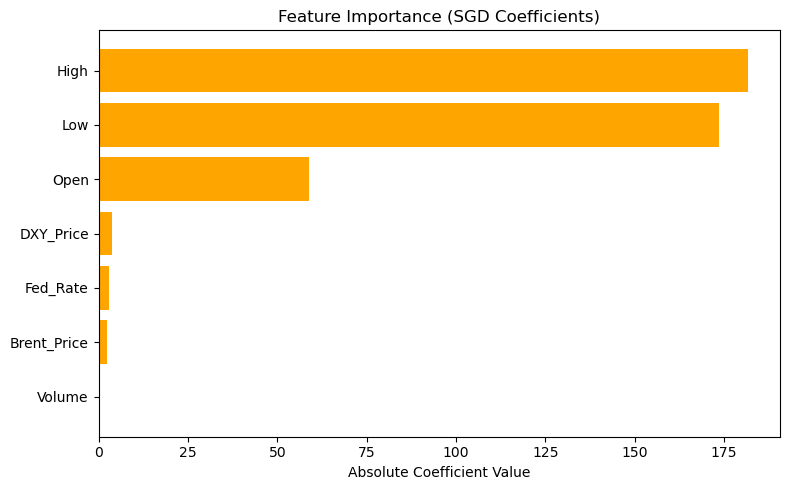

In [36]:
# FEATURE IMPORTANCE — SGD COEFFICIENTS
print("\n" + "="*70)
print("📌 FEATURE IMPORTANCE (SGD COEFFICIENTS)")
print("="*70)

# Extract SGD model from pipeline
sgd_model = pipeline.named_steps["sgd"]

# Create dataframe with coefficients
coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": sgd_model.coef_
})

# Sort by absolute value for importance
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

print(coef_df)

# Plot
plt.figure(figsize=(8,5))
plt.barh(coef_df["Feature"], coef_df["Abs_Coefficient"], color="#FFA500")
plt.gca().invert_yaxis()
plt.xlabel("Absolute Coefficient Value")
plt.title("Feature Importance (SGD Coefficients)")
plt.tight_layout()
plt.show()


The coefficient indicates how strongly a feature affects the target: positive values increase gold price predictions, while negative values decrease them.

- High and Low prices are the most influential features, reflecting the daily price range’s strong effect on the closing price.

- Open price has a moderate negative impact.

- Federal Funds Rate negatively influences gold price, consistent with economic theory: lower interest rates tend to support higher gold prices.

- Brent Oil and DXY Prices have minor impacts, while Volume is negligible in this model.

## Next Day Prediction

In [37]:
# NEXT DAY PREDICTION
print("\n🔮 NEXT DAY PREDICTION\n" + "="*70)

df_pred = merge_features(
    fetch_gold(pipeline.last_train_date - timedelta(days=10), pipeline.last_train_date),
    fetch_brent(pipeline.last_train_date - timedelta(days=10), pipeline.last_train_date),
    fetch_dxy(pipeline.last_train_date - timedelta(days=10), pipeline.last_train_date),
    fetch_fed(pipeline.last_train_date - timedelta(days=10), pipeline.last_train_date)
)
df_pred = df_pred.dropna(subset=feature_cols)

if not df_pred.empty:
    last_row = df_pred.iloc[-1]
    last_date = last_row["Date"].date()
    next_date = next_trading_day(last_date)

    
    X_pred_df = pd.DataFrame([last_row[feature_cols]], columns=feature_cols)
    predicted_price = pipeline.predict(X_pred_df)[0]

    print(f"📅 Most recent data date: {last_date}")
    print(f"🔮 Predicted Gold Price for {next_date}: ${predicted_price:.2f}")



🔮 NEXT DAY PREDICTION
📅 Most recent data date: 2026-01-08
🔮 Predicted Gold Price for 2026-01-09: $4470.55


MAE: 14.47 | MAPE: 0.41%


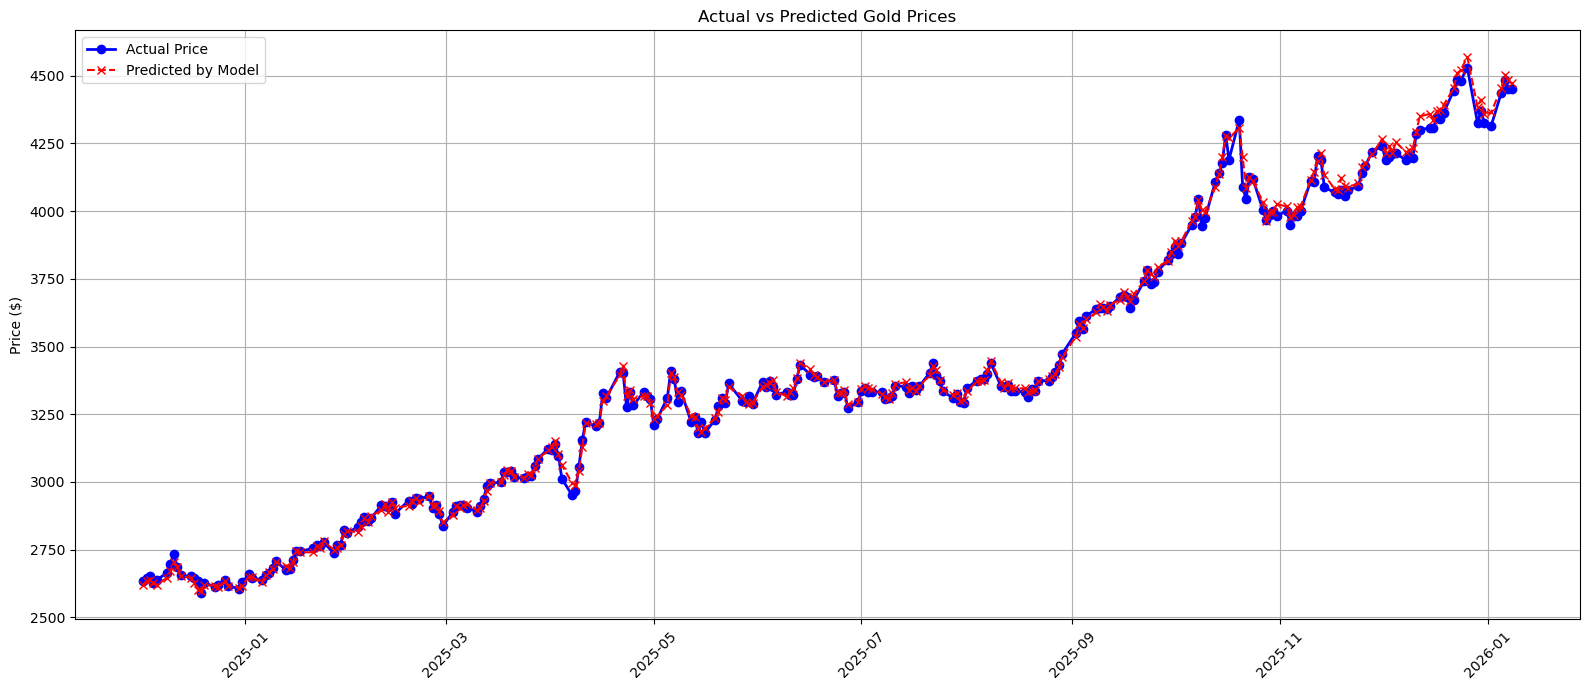

In [38]:
# EVALUATION (MAE + MAPE)
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

start_date = datetime(2024, 11, 30).date()  
end_date = pipeline.last_train_date

gold = fetch_gold(start_date, end_date)
brent = fetch_brent(start_date, end_date)
dxy = fetch_dxy(start_date, end_date)
fed = fetch_fed(start_date, end_date)

df_show = merge_features(gold, brent, dxy, fed)
df_show = df_show.dropna(subset=feature_cols + ["Gold_Price"]).reset_index(drop=True)

if len(df_show) >= 5:
    X_show = df_show[feature_cols]
    predictions = pipeline.predict(X_show)
    df_show["Predicted"] = predictions

    # Compute MAE & MAPE
    mae = mean_absolute_error(df_show["Gold_Price"], df_show["Predicted"])
    mape = mean_absolute_percentage_error(df_show["Gold_Price"], df_show["Predicted"])
    print(f"MAE: {mae:.2f} | MAPE: {mape*100:.2f}%")

    # Plot Actual vs Predicted
    plt.figure(figsize=(16, 7))
    plt.plot(df_show["Date"], df_show["Gold_Price"], "o-", color="blue", label="Actual Price", linewidth=2)
    plt.plot(df_show["Date"], df_show["Predicted"], "x--", color="red", label="Predicted by Model")
    plt.title("Actual vs Predicted Gold Prices")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



- **Mean Absolute Error (MAE):** 14.47
  *On average, predictions deviate from actual gold prices by $14.47.*

- **Mean Absolute Percentage Error (MAPE):** .41%  
  *The average prediction error is 1% of the actual price — excellent accuracy for time-series forecasting.*


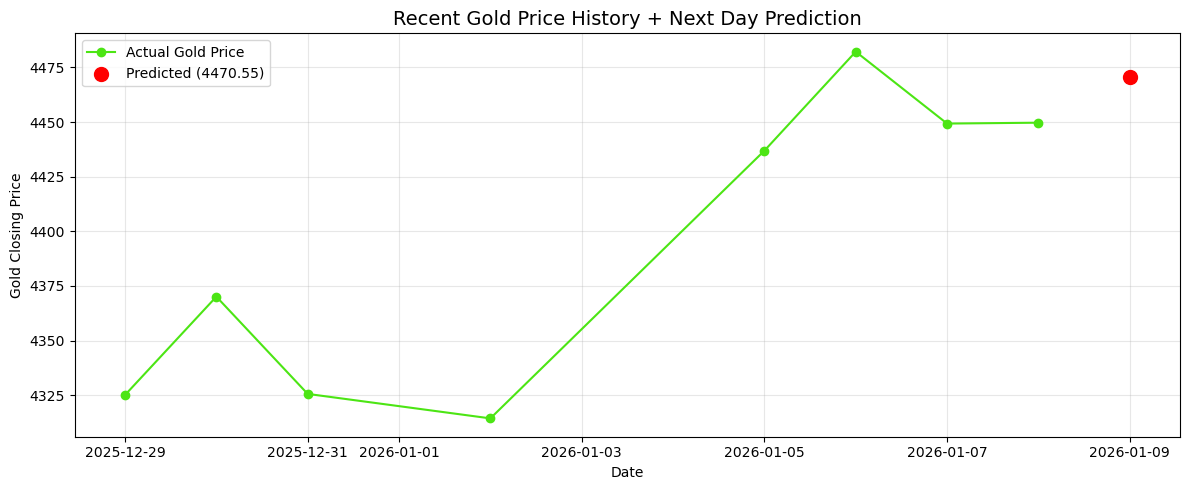

In [39]:
# Show recent history for context
recent_history = df_pred.tail(10)
plt.figure(figsize=(12, 5))
plt.plot(recent_history["Date"], recent_history["Gold_Price"],
             label="Actual Gold Price", marker="o", linestyle="-", color="#4CE514")
plt.scatter(pd.to_datetime(next_date), predicted_price,
                color="red", s=100, label=f"Predicted ({predicted_price:.2f})", zorder=5)
plt.title("Recent Gold Price History + Next Day Prediction", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Gold Closing Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()